# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [161]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor 
from xgboost.sklearn import XGBRegressor 

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias_eng = pd.read_csv('azdias_df.csv', sep=',',dtype={'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015':object})

Due to memory shortage on the machine where this notebook is written on I will reduce the size of the the azdias_eng to 50 %. I experienced massive problems with the handling of the dataframe. Anyhow all the steps and analysis can be done without reducing the size on a more powerful machine.

In [3]:
# select randomly 50% of the rows
azdias_eng = azdias_eng.sample( n= int(0.50*(azdias_eng.shape[0])))

In [4]:
# first overview of the dataframe
azdias_eng.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
126949,126949,829778,-1,6.0,16.0,NaN,NaN,NaN,NaN,16.0,...,4.0,10.0,10.0,7.0,0.0,9.0,2.0,6,2,3
387530,387530,551191,1,1.0,11.0,NaN,NaN,NaN,NaN,11.0,...,1.0,9.0,6.0,3.0,6.0,9.0,7.0,3,2,3
534777,534777,747918,-1,9.0,19.0,6.0,NaN,NaN,NaN,24.0,...,3.0,3.0,6.0,5.0,1.0,9.0,7.0,4,2,3
881264,881264,569540,-1,2.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,10.0,12.0,9.0,4.0,9.0,4.0,3,1,3
572443,572443,968754,-1,8.0,21.0,17.0,NaN,NaN,NaN,21.0,...,NaN,2.0,3.0,5.0,1.0,9.0,0.0,2,1,1


In [5]:
# drop 'Unnamed: 0' because it is just a duplicate of the index
azdias_eng = azdias_eng.iloc[:,1:]

In [6]:
# get dimensions of the dataframe
azdias_eng.shape

(445610, 366)

The data has 366 columns. These have to be explored and attributed. For that I created a dataframe with metadata which pandas provides for each column . These metadata are the column name, the number of unique values, the dtype, a list of all unique values and the number of missing values of each column.

In [7]:
# create a dataframe with metadata about every column 

# create empty dataframe
column_metadata = pd.DataFrame(columns=['col_name', 'val_number', 'dtype', 'nan_number', 'category:count'])

# create array of columns
columns_list = azdias_eng.columns

# fill dataframe with column attributes
for i in range(len(columns_list)):
    val_count = azdias_eng.iloc[:,i].value_counts(dropna=False)
    column_metadata = column_metadata.append({'col_name': columns_list[i], 'val_number': len(val_count),
                   'dtype': azdias_eng.iloc[:,i].dtype, 'nan_number':azdias_eng.iloc[:,i].isnull().sum(),
                    'category:count': val_count.index.tolist()}, ignore_index=True)

In [8]:
# overview of column_metadata
column_metadata.head(3)

,col_name,val_number,dtype,nan_number,category:count
0,LNR,445610,int64,0,"[1050623, 462411, 302649, 298555, 308796, 3108..."
1,AGER_TYP,5,int64,0,"[-1, 2, 1, 3, 0]"
2,AKT_DAT_KL,10,float64,37071,"[1.0, 9.0, nan, 5.0, 6.0, 3.0, 4.0, 7.0, 8.0, ..."


column_metadata and the two excel files 'DIAS Information Levels - Attributes 2017.xlsx' and 'DIAS Attributes - Values 2017.xlsx' which describe the columns were the basis to label each column for the data type and NaNs which are encoded in each column and not labeled as NaNs. This labeling was done by hand in an excel file named 'column_mapper2.xlsx' .

In [9]:
# load excel file which specifies the columns into dataframe
column_metadata2 = pd.read_excel('column_mapper2.xlsx')

In [10]:
# overview of column_metadata
column_metadata2.head(3)

,format,to_nan,Unnamed: 2,col_name,val_number,dtype,nan_number,category:count
0,num,no,0,LNR,891221,int64,0,"(192418, 1)(611455, 1)(982154, 1)(976009, 1)(9..."
1,cat,minus1,1,AGER_TYP,5,int64,0,"(-1, 677503)(2, 98472)(1, 79802)(3, 27104)(0, ..."
2,inter,minus1,2,AKT_DAT_KL,10,float64,73499,"(1.0, 390258)(9.0, 270663)(nan, 73499)(5.0, 29..."


In [11]:
# drop 'Unnamed: 2' because it is just a copy of the index
column_metadata2.drop('Unnamed: 2', axis=1, inplace=True)

# take the list of unique values for each column and replace the text value (datastructure was lost in excel conversion)
column_metadata2['category:count']=column_metadata['category:count']

In [12]:
# overview of column_metadata
column_metadata2.head(3)

,format,to_nan,col_name,val_number,dtype,nan_number,category:count
0,num,no,LNR,891221,int64,0,"[1050623, 462411, 302649, 298555, 308796, 3108..."
1,cat,minus1,AGER_TYP,5,int64,0,"[-1, 2, 1, 3, 0]"
2,inter,minus1,AKT_DAT_KL,10,float64,73499,"[1.0, 9.0, nan, 5.0, 6.0, 3.0, 4.0, 7.0, 8.0, ..."


In [13]:
# Show all the different data types for the columns according to column_metadat2
# ord = ordinal, cat=categorical, inter=interval, num=numeric, bin=binary
column_metadata2['format'].value_counts()

ord      294
cat       32
inter     16
num       14
bin       10
Name: format, dtype: int64

In [14]:
# the column dtype shows the pandas dtype for each column, 6 columns have object as dtype and need special attention
column_metadata2[column_metadata2['dtype']=='object']

,format,to_nan,col_name,val_number,dtype,nan_number,category:count
17,cat,no,CAMEO_DEU_2015,46,object,98979,"[nan, 6B, 8A, 4C, 2D, 3C, 7A, 3D, 4A, 8B, 8C, ..."
18,cat,minus1,CAMEO_DEUG_2015,11,object,98979,"[8, 9, 6, 4, nan, 3, 2, 7, 5, 1, X]"
19,cat,minus1,CAMEO_INTL_2015,23,object,98979,"[51, nan, 41, 24, 14, 43, 54, 25, 22, 23, 45, ..."
61,cat,no,D19_LETZTER_KAUF_BRANCHE,36,object,257113,"[nan, D19_UNBEKANNT, D19_VERSICHERUNGEN, D19_S..."
97,inter,no,EINGEFUEGT_AM,5163,object,93148,"[1992-02-10 00:00:00, 1992-02-12 00:00:00, nan..."
317,bin,minus1,OST_WEST_KZ,3,object,93148,"[W, O, nan]"


In [15]:
# three columns contain 'X' or 'XX', values which have the meaning explained in the excel files for the attributes
# these are replaced with NaNs and the columns are converted to float if possible
azdias_eng['CAMEO_DEU_2015'] = azdias_eng['CAMEO_DEU_2015'].replace('XX', np.nan)
azdias_eng['CAMEO_DEUG_2015'] = azdias_eng['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
azdias_eng['CAMEO_INTL_2015'] = azdias_eng['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)

# D19_UNBEKANNT ('unbekannt' german for 'unknown') is not decoded as unknow in the excel files for the attributes but
# will be converted here
azdias_eng['D19_LETZTER_KAUF_BRANCHE'] = azdias_eng['D19_LETZTER_KAUF_BRANCHE'].replace('D19_UNBEKANNT', np.nan)

# this is a date where the first four letters represent the year and the column will be replaced with this as float
azdias_eng['EINGEFUEGT_AM'] = azdias_eng['EINGEFUEGT_AM'].str.slice(0,4).astype(float)

# this binary is encoded as numbers
azdias_eng['OST_WEST_KZ'] = azdias_eng['OST_WEST_KZ'].replace(['O', 'W'], [0,1])

#after this engineering there are still two column with dtype='object' but they are categorical and can be converted
#during one-hot-encoding('D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015')

In [16]:
# Show all the different values which are encoded as unknown and will be converted to NaNs for the columns according to
# column_metadat2. no=no conversion, minus1=-1, zero=0, minus1_nine=-1,9 , minus1_zero=-1,0
column_metadata2['to_nan'].value_counts()

minus1         142
no             129
minus1_nine     75
minus1_zero     11
zero             9
Name: to_nan, dtype: int64

In [17]:
# convert all unknown encoded data to NaNs

# loop over all columns
for i in range(len(column_metadata2)):
    to_nan = column_metadata2.iloc[i]['to_nan']
    category_count = column_metadata2.iloc[i]['category:count']
    col_name = column_metadata2.iloc[i]['col_name']
        
    # check for nan-conversin-label and if this value exists in this column,
    if (to_nan == 'minus1'):
        azdias_eng[col_name] = azdias_eng[col_name].replace([-1, -1.0], [np.nan, np.nan])
        
    elif (to_nan == 'zero'):
        azdias_eng[col_name] = azdias_eng[col_name].replace([-1, -1.0], [np.nan, np.nan])
    
    elif (to_nan == 'minus1_nine'):
        azdias_eng[col_name] = azdias_eng[col_name].replace([-1, 9, -1.0, 9.0], [np.nan, np.nan, np.nan, np.nan])
    
    elif (to_nan == 'minus1_nine'):
        azdias_eng[col_name] = azdias_eng[col_name].replace([-1, 9, -1.0, 9.0], [np.nan, np.nan, np.nan, np.nan])

In [18]:
# calculate the percentage of missing values per column
missing_per_column = (azdias_eng.isnull().sum().sort_values(ascending=False)/azdias_eng.shape[0]*100)
missing_per_column.head(25)

ALTER_KIND4                    99.866026
ALTER_KIND3                    99.302978
ALTER_KIND2                    96.709903
ALTER_KIND1                    90.922107
AGER_TYP                       75.999641
EXTSEL992                      73.438433
KK_KUNDENTYP                   65.715536
D19_LETZTER_KAUF_BRANCHE       50.874756
ALTERSKATEGORIE_FEIN           29.469940
D19_KONSUMTYP                  28.913624
D19_BANKEN_ONLINE_QUOTE_12     28.913624
D19_VERSAND_ONLINE_QUOTE_12    28.913624
D19_TELKO_ONLINE_QUOTE_12      28.913624
D19_SOZIALES                   28.913624
D19_GESAMT_ONLINE_QUOTE_12     28.913624
D19_LOTTO                      28.913624
D19_VERSI_ONLINE_QUOTE_12      28.913624
KBA05_AUTOQUOT                 16.712372
KBA05_MOD8                     16.711923
KBA05_SEG1                     16.711923
KBA05_MOTOR                    16.711923
KBA05_MOD1                     16.711923
KBA05_MOD4                     16.711923
KBA05_MOD3                     16.711923
KBA05_MOD2      

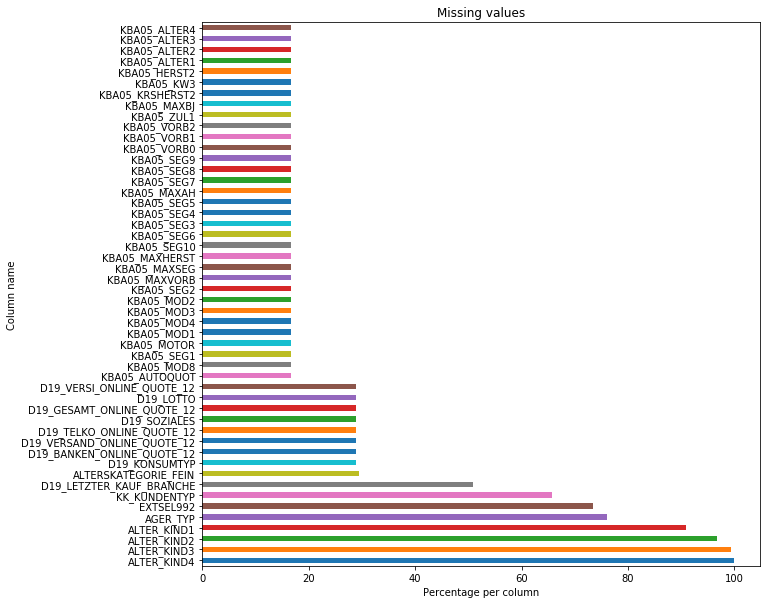

In [19]:
# plot horizontal barplot of columns with the top 50 highest percentage of missing values
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

missing_per_column.head(50).plot.barh()

plt.title('Missing values')
plt.xlabel("Percentage per column")
plt.ylabel('Column name')
plt.show()

Here the decision was made to drop all columns with more than 20 percent of missing data.

In [20]:
# make list of all columns that have more than 20 % of missing values and show length
drop_list_20percent = missing_per_column[missing_per_column>20].index.tolist()
print('{} columns are dropped'.format(len(drop_list_20percent)))
drop_list_20percent

17 columns are dropped


['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'ALTERSKATEGORIE_FEIN',
 'D19_KONSUMTYP',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_SOZIALES',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_LOTTO',
 'D19_VERSI_ONLINE_QUOTE_12']

In [21]:
# drop the columns and show new shape
azdias_eng.drop(drop_list_20percent, axis=1, inplace=True)
azdias_eng.shape

(445610, 349)

In [22]:
# create series of count of distinct percentages of missing values per row
missing_in_rows = (azdias_eng.isnull().sum(axis=1)/azdias_eng.shape[1]*100).round().astype(int).value_counts().sort_index()

In [23]:
'Number of rows with no missing values: {}'.format(missing_in_rows[0])

'Number of rows with no missing values: 325996'

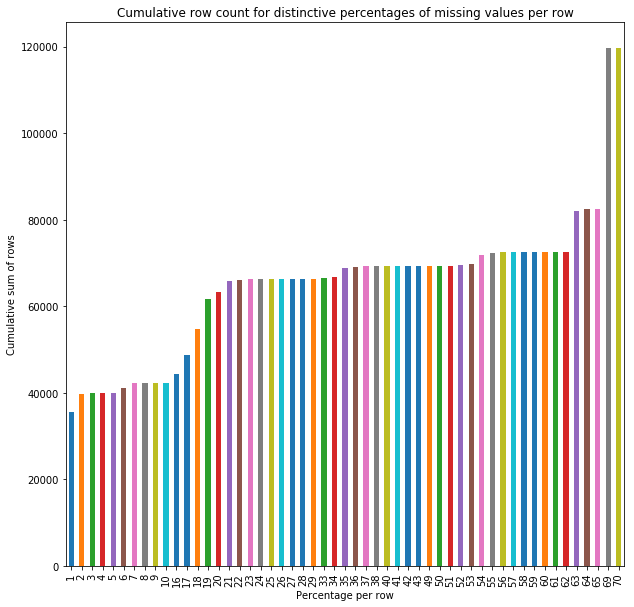

In [24]:
# plot barplot for cumulative number of rows for distinctive percentages of missing values per row
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

missing_in_rows[1:].cumsum().plot.bar()

plt.title('Cumulative row count for distinctive percentages of missing values per row')
plt.xlabel("Percentage per row")
plt.ylabel('Cumulative sum of rows')
plt.show()

There are arount 320,000 rows with no missing values. With the graph above you can evaluate how many rows you include additionally to the 320,000 if you allow a certain percentage of missing values. For example if you include rows with up 18% of missing values you will add around 50,000 rows, if you allow 63 % you will add around 70,000 rows. If you decide to allow up to 9% percent of missing values per row then 40,000 rows are added like explored below.
The two datasets,one with the excluded and one with the included rows, are compared at random, to check if the distribution of values has changed.

In [25]:
# build two dataframes with rows which are included and with rows which are excluded
azdias_eng_10percent_row = azdias_eng[(azdias_eng.isnull().sum(axis=1)/azdias_eng.shape[1]*100)<10]
azdias_eng_10percent_row_excluded_rows = azdias_eng[(azdias_eng.isnull().sum(axis=1)/azdias_eng.shape[1]*100)>10]

In [26]:
#create list of randomly selected columns to check on if the distributions in the datasets are the same
np.random.seed(10)
check_columns = list(np.random.choice(azdias_eng_10percent_row.columns, 5))
check_columns

['KBA13_SEG_MINIWAGEN',
 'KBA05_HERST5',
 'CJT_KATALOGNUTZER',
 'SEMIO_KULT',
 'KBA05_HERST3']

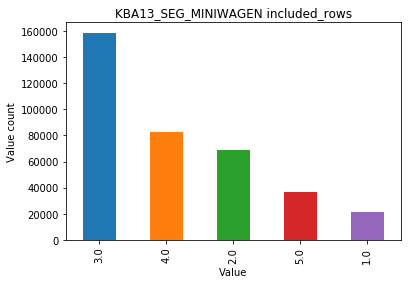

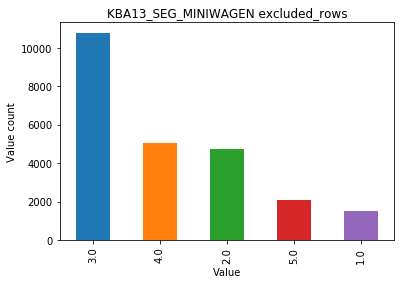

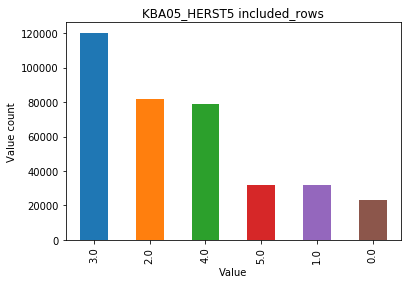

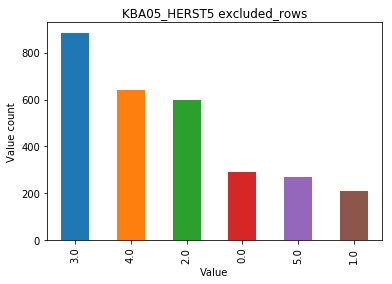

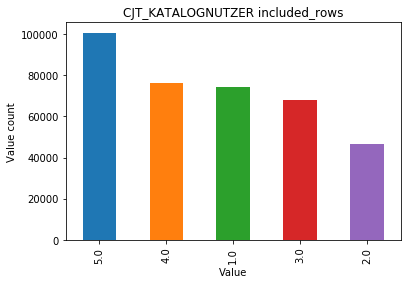

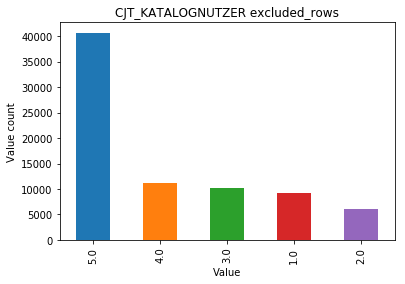

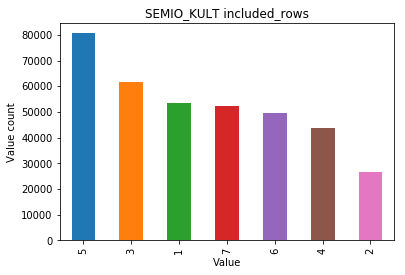

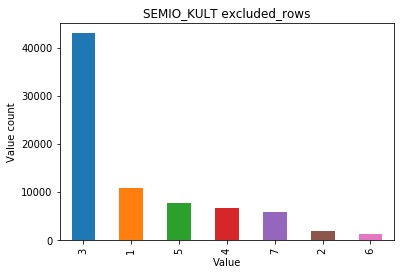

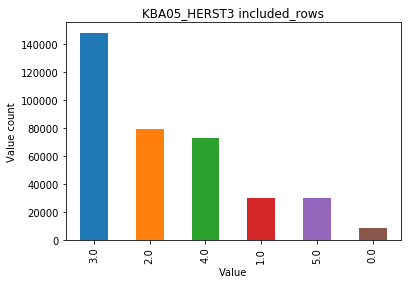

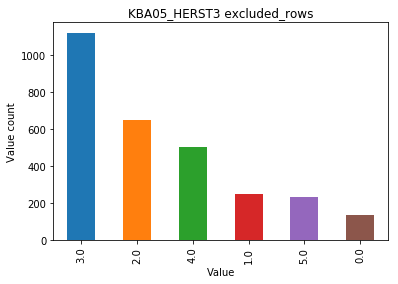

In [27]:
# build figure to compare the distribution of 5 columns


for i, column in enumerate(check_columns):

    
    azdias_eng_10percent_row[column].value_counts().plot.bar()
    
    plt.title(column +' included_rows')
    plt.xlabel("Value")
    plt.ylabel('Value count')
    plt.show()
    

    
    azdias_eng_10percent_row_excluded_rows[column].value_counts().plot.bar()
    
    plt.title(column + ' excluded_rows')
    plt.xlabel("Value")
    plt.ylabel('Value count')
    plt.show()

Overall it looks like the distributions of the values are similar.

In [28]:
# impute all NaNs in the dataframe, for numeric columns with the mean, for other column with mode
for column in azdias_eng.columns.tolist():
    if (column_metadata2[column_metadata2['col_name']==column]['format']=='num').iloc[0]:
        azdias_eng[column].fillna(azdias_eng[column].mean(), inplace=True)

    else:
        azdias_eng[column].fillna(azdias_eng[column].mode()[0], inplace=True)

The categorical columns have to be encoded for the machine learning. First I sort all category columns by the number of their unique values because in one-hot-encoding this number decides the number of new columns which are created.

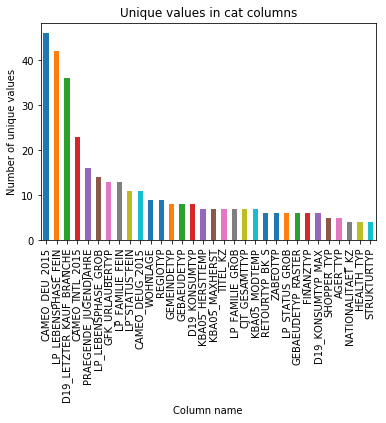

In [29]:
# create a plot with unique values per categorical column
cat_column_meta = column_metadata2[column_metadata2['format']=='cat'].sort_values('val_number', ascending=False)
pd.Series(cat_column_meta['val_number'].values, index=cat_column_meta['col_name']).plot.bar()
plt.title('Unique values in cat columns')
plt.ylabel('Number of unique values')
plt.xlabel('Column name')
plt.show()

In [32]:
# I decided to encode only categorical values with less than 6 unique values due to memory shortage and drop the rest
cat_col_7_unique = cat_column_meta[cat_column_meta['val_number']<7]['col_name'].tolist()
cat_col_drop = cat_column_meta[cat_column_meta['val_number']>=7]['col_name'].tolist()
print('The columns to one-hot-encode are:' , cat_col_7_unique)
print('')
print('The columns to drop are: ',cat_col_drop)

The columns to one-hot-encode are: ['RETOURTYP_BK_S', 'ZABEOTYP', 'LP_STATUS_GROB', 'GEBAEUDETYP_RASTER', 'FINANZTYP', 'D19_KONSUMTYP_MAX', 'SHOPPER_TYP', 'AGER_TYP', 'NATIONALITAET_KZ', 'HEALTH_TYP', 'STRUKTURTYP']

The columns to drop are:  ['CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_GROB', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'WOHNLAGE', 'REGIOTYP', 'GEMEINDETYP', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'TITEL_KZ', 'LP_FAMILIE_GROB', 'CJT_GESAMTTYP', 'KBA05_MODTEMP']


In [33]:
# choose only columns to encode which are still in the dataframe
cat_col_set = set(cat_col_7_unique)
col_set = set(azdias_eng.columns)
one_hot_list = list(col_set.intersection(cat_col_set))
one_hot_list

['NATIONALITAET_KZ',
 'D19_KONSUMTYP_MAX',
 'GEBAEUDETYP_RASTER',
 'FINANZTYP',
 'LP_STATUS_GROB',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'RETOURTYP_BK_S',
 'HEALTH_TYP',
 'STRUKTURTYP']

In [34]:
# choose only columns to drop which are still in the dataframe
cat_col_set = set(cat_col_drop)
col_set = set(azdias_eng.columns)
cat_drop_list = list(col_set.intersection(cat_col_set))
cat_drop_list

['KBA05_MODTEMP',
 'PRAEGENDE_JUGENDJAHRE',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'GEBAEUDETYP',
 'KBA05_HERSTTEMP',
 'LP_FAMILIE_FEIN',
 'GFK_URLAUBERTYP',
 'WOHNLAGE',
 'GEMEINDETYP',
 'KBA05_MAXHERST',
 'TITEL_KZ',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'CAMEO_DEUG_2015',
 'REGIOTYP',
 'LP_LEBENSPHASE_GROB',
 'CAMEO_INTL_2015',
 'LP_STATUS_FEIN']

In [35]:
#one-hot-encode the chosen columns
azdias_eng = pd.get_dummies(data=azdias_eng, columns=one_hot_list)

In [36]:
# drop category columns with more than 6 unique values
azdias_eng.drop(cat_drop_list, axis=1, inplace=True)

In [37]:
# show shape of the dataframe
azdias_eng.shape

(445610, 367)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

To find cluster in the dataset the algorithm KMeans will be used and to do that a principal component analysis will take place. In order to calculate PCA the dataframe has to be standardized with the sklearn StandardScaler.

In [38]:
#instanitate scaler
scaler = preprocessing.StandardScaler()

In [39]:
# make array out of dataframe values
azdias_scaler_array = azdias_eng.values

In [40]:
#standardize the columns and build new standardized dataframe
azdias_scaler_df = pd.DataFrame(scaler.fit_transform(azdias_scaler_array), columns = list(azdias_eng.columns))

In [41]:
# caclulate PCA
pca = PCA()
azdias_eng_pca = pca.fit(azdias_scaler_df)

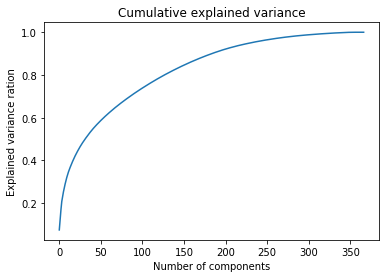

In [43]:
# Plot cumulative explained variance
explained_variance_ratio = azdias_eng_pca.explained_variance_ratio_
cumulative_evr = np.cumsum(explained_variance_ratio)
plt.plot(range(len(cumulative_evr)), cumulative_evr)
plt.title('Cumulative explained variance')
plt.ylabel('Explained variance ration')
plt.xlabel('Number of components')
plt.show()

In [44]:
# choose 200 components because the gain of explained variance starts to cost too much more components
pca = PCA(200)
azdias_eng_pca_data = pca.fit_transform(azdias_scaler_df)

In [47]:
# print the top ten Dimensions with the highest explained variance ratio

def weights_of_pca(df, pca):
    '''
    create dataframe for the components sorted by explained variance ratio and weights for each feature
    input: dataframe with scaled and cleaned data, pca
    output: dataframe for each feature with weights and explained variance ratio
       
    
    '''
    
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    weights_df = pd.concat([variance_ratios, components], axis = 1)
    
    return weights_df

weights_df = weights_of_pca(azdias_scaler_df, pca)
weights_df.head(10)

,Explained Variance,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,RETOURTYP_BK_S_2.0,RETOURTYP_BK_S_3.0,RETOURTYP_BK_S_4.0,RETOURTYP_BK_S_5.0,HEALTH_TYP_1.0,HEALTH_TYP_2.0,HEALTH_TYP_3.0,STRUKTURTYP_1.0,STRUKTURTYP_2.0,STRUKTURTYP_3.0
Dimension 1,0.0747,0.0194,-0.0579,0.0631,-0.0755,-0.0186,0.0365,0.0810,-0.0745,0.0024,...,0.0347,0.0029,0.0169,-0.0318,0.0212,0.0079,-0.0240,0.0671,0.0398,-0.0827
Dimension 2,0.0483,-0.0540,0.0014,0.0987,0.0168,-0.0102,0.0529,0.0557,0.0143,-0.0076,...,0.0428,-0.0265,0.0442,-0.0738,-0.0061,0.0009,0.0039,0.0174,0.0015,-0.0148
Dimension 3,0.0466,0.0611,0.0173,0.0530,0.0329,0.0241,0.0249,0.0204,0.0301,0.0081,...,0.0256,-0.0410,0.0095,-0.0059,-0.0049,0.0042,-0.0002,-0.0835,-0.0312,0.0893
Dimension 4,0.0386,-0.0445,-0.0479,0.0145,0.0360,0.0213,-0.0358,0.0106,0.0383,0.0089,...,-0.0017,-0.0108,-0.0495,0.1144,0.0435,0.0567,-0.0876,-0.0267,-0.0124,0.0304
Dimension 5,0.0233,-0.0955,-0.0664,-0.0369,0.0061,0.0134,0.0222,0.0314,0.0086,0.0071,...,0.0239,0.0652,-0.0273,-0.0390,-0.0246,-0.0219,0.0399,-0.0437,-0.0327,0.0590
Dimension 6,0.0215,-0.0822,0.1070,0.0445,0.0105,0.0059,-0.0287,-0.0543,0.0111,0.0004,...,-0.0640,-0.0476,0.0532,-0.0062,0.0296,0.0301,-0.0515,0.0694,0.0477,-0.0905
Dimension 7,0.0185,0.0099,-0.0584,-0.0230,-0.0277,-0.0048,-0.0145,0.0297,-0.0280,0.0080,...,-0.1105,0.0392,0.0270,0.0072,0.0167,-0.0509,0.0355,-0.0585,-0.0368,0.0737
Dimension 8,0.0177,0.0003,-0.0728,-0.0395,0.0229,0.0063,0.0100,0.0434,0.0212,0.0042,...,-0.0245,0.0595,0.0140,-0.0075,0.0091,-0.0669,0.0567,0.0478,-0.0004,-0.0375
Dimension 9,0.0164,0.0049,0.0076,0.0040,-0.0217,-0.0065,0.0035,0.0188,-0.0218,0.0007,...,0.0057,-0.0150,-0.0235,0.0066,0.0003,-0.0190,0.0178,-0.0696,-0.0239,0.0728
Dimension 10,0.0146,0.0767,0.0050,0.0141,0.0796,0.0028,0.0010,-0.0010,0.0804,-0.0145,...,-0.0224,-0.0394,-0.0035,0.0458,0.0226,-0.0069,-0.0109,-0.0679,0.0042,0.0506


The principal components are the eigenvectors and the weights are the coordinates of these vectors. So if the absolute values of the weights of certain features are similar between components then these principal componenent vectors tend to point in the same direction(values equal) or the opposite direction(values equal to negative of value) for this feature. In the figures below you can see the top5 positive and negative weights for the top3 prinicipal components

In [48]:
# weights for the first principal component
weights_1 = (weights_df.iloc[0]).sort_values(ascending=False)
print(weights_1.head())
print('')
print(weights_1.tail())

PLZ8_ANTG1     0.1330
KBA13_ANTG1    0.1320
MOBI_RASTER    0.1299
MOBI_REGIO     0.1285
KBA05_ANTG1    0.1229
Name: Dimension 1, dtype: float64

KBA13_BAUMAX   -0.1134
VK_DHT4A       -0.1135
EWDICHTE       -0.1144
PLZ8_ANTG3     -0.1331
KBA13_ANTG3    -0.1333
Name: Dimension 1, dtype: float64


In [49]:
# weights for the second principal component
weights_2 = (weights_df.iloc[1]).sort_values(ascending=False)
print(weights_2.head())
print('')
print(weights_2.tail())

D19_GESAMT_ANZ_24     0.1298
ONLINE_AFFINITAET     0.1259
D19_GESAMT_ANZ_12     0.1215
D19_VERSAND_ANZ_24    0.1170
D19_VERSAND_ANZ_12    0.1071
Name: Dimension 2, dtype: float64

VK_DHT4A                   -0.1190
D19_VERSAND_ONLINE_DATUM   -0.1196
KOMBIALTER                 -0.1227
D19_GESAMT_DATUM           -0.1231
D19_GESAMT_ONLINE_DATUM    -0.1244
Name: Dimension 2, dtype: float64


In [50]:
# weights for the third principal component
weights_3 = weights_df.iloc[2].sort_values(ascending=False)
print(weights_3.head())
print('')
print(weights_3.tail())

KBA13_HERST_BMW_BENZ           0.1648
KBA13_SEG_OBEREMITTELKLASSE    0.1434
KBA13_BMW                      0.1405
KBA13_MERCEDES                 0.1385
KBA13_SITZE_4                  0.1369
Name: Dimension 3, dtype: float64

KBA13_SEG_KLEINWAGEN   -0.1130
KBA13_ALTERHALTER_60   -0.1158
KBA13_KMH_140_210      -0.1162
KBA13_HALTER_20        -0.1170
KBA13_SITZE_5          -0.1365
Name: Dimension 3, dtype: float64


To find typical customer segments the KMeans algorithm is choosen which calculates cluster on the components after principal component analysis.

In [51]:
# create cluster over a number of different cluster counts and calculate scores

cluster_choice = {}
for cluster_number in range(10,20,3):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=cluster_number)
    kmeans.fit(azdias_eng_pca_data)
    
    # compute the average within-cluster distances.
    score = kmeans.score(azdias_eng_pca_data)
    cluster_choice[cluster_number] = score
    
    print(str(cluster_number)+' cluster KMean calculated')

10 cluster KMean calculated
13 cluster KMean calculated
16 cluster KMean calculated
19 cluster KMean calculated


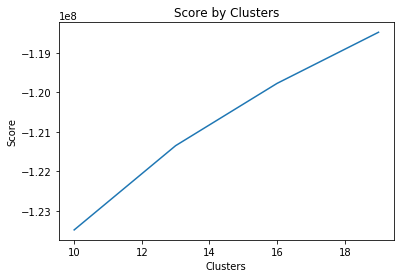

In [52]:
# plot the scores for different cluster sizes

scores = []
for key in cluster_choice.keys():
    scores.append(cluster_choice[key])

plt.plot(cluster_choice.keys(), scores)
plt.title('Score by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.show()

In [53]:
# following the elbow method choosing the number clusters as 13
kmeans = KMeans(n_clusters=13)
kmeans.fit(azdias_eng_pca_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [54]:
# save kmeans model to a pickle to save time when reopening the notebook to work on
pkl_filename = "kmeans_13_cluster.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(kmeans, file)

In [55]:
# create predictions for the population data
population_prediction = kmeans.predict(azdias_eng_pca_data)

In [56]:
# load data for customers
customers_df = pd.read_csv('customers_df.csv', sep=',', dtype={'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015':object})

In [57]:
# overview of customers data
customers_df.head(5)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [58]:
# drop 'Unnamed: 0' because it is just a duplicate of the index
customers_df = customers_df.iloc[:,1:]

In [59]:
# remove columns which are not present in the population data
customers_eng = customers_df[customers_df.columns.difference(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'])]

In [60]:
# show shape of customer data
customers_eng.shape

(191652, 366)

In [67]:
# create cleaning function for the customer data, the cleaning process has to be analogue to the process of the population
# to use the same kmean object and the singular steps of cleaning are explained above

def cleaning_function(df1):
    '''
       function to clean and prepare the data of customers for using with the same kmeans object
       input:dataframe raw
       output:dataframe cleaned
    '''
    df = df1.copy()
        
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)

    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].replace('D19_UNBEKANNT', np.nan)
    df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].str.slice(0,4).astype(float)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['O', 'W'], [0,1])
    
    for i in range(len(column_metadata2)):
        to_nan = column_metadata2.iloc[i]['to_nan']
        col_name = column_metadata2.iloc[i]['col_name']
      
        if (to_nan == 'minus1'):
            df[col_name] = df[col_name].replace([-1, -1.0], [np.nan, np.nan])
        
        elif (to_nan == 'zero'):
            df[col_name] = df[col_name].replace([-1, -1.0], [np.nan, np.nan])
    
        elif (to_nan == 'minus1_nine'):
            df[col_name] = df[col_name].replace([-1, 9, -1.0, 9.0], [np.nan, np.nan, np.nan, np.nan])
    
        elif (to_nan == 'minus1_nine'):
            df[col_name] = df[col_name].replace([-1, 9, -1.0, 9.0], [np.nan, np.nan, np.nan, np.nan])
        
    df.drop(drop_list_20percent, axis=1, inplace=True)
    
      
    for column in df.columns.tolist():
        if (column_metadata2[column_metadata2['col_name']==column]['format']=='num').iloc[0]:
            df[column].fillna(df[column].mean(), inplace=True)

        else:
            df[column].fillna(df[column].mode()[0], inplace=True)
    
    
    df = pd.get_dummies(data=df, columns=one_hot_list)
    df.drop(cat_drop_list, axis=1, inplace=True)
    
    df_scaler_array = df.values
    scaler_df = pd.DataFrame(scaler.fit_transform(df_scaler_array), columns=df.columns.tolist())
    
    
    return scaler_df

In [68]:
#apply cleaning function to customer data
clean_customers = cleaning_function(customers_eng)

In [70]:
#create predictions for costumers with the kmeans object used for
pca_data_customer = pca.transform(clean_customers)
customer_prediction = kmeans.predict(pca_data_customer)

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#create distribution of proportions of clusters

customer_distribution = pd.Series(customer_prediction).value_counts()
population_distribution = pd.Series(population_prediction).value_counts()

customer_distribution = customer_distribution / len(customer_prediction)

population_distribution = population_distribution / len(population_prediction)

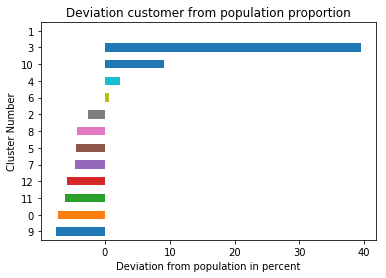

In [72]:
#print in graph the difference of proportion between customer and population
a= customer_distribution.sort_index()
b =population_distribution.sort_index()

cust_pop_difference = (a-b).sort_values()*100
cust_pop_difference.plot.barh()
plt.title('Deviation customer from population proportion')
plt.xlabel('Deviation from population in percent')
plt.ylabel('Cluster Number')
plt.show()


In the graph above you can clearly see that cluster 3 is overrepresented in the customers and cluster 9 or 0 are underrepresented.

In [93]:
#create dataframe for clustercenters which are transformed back from pca and scaling, so the values can be compared
k = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
cluster_dataframe = pd.DataFrame(np.array(k), columns=clean_customers.columns)

In [99]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#cluster 3 is overrepresented in the customer-dataset

print('The age by column ALTERSKATEGORIE_GROB is {} which translates to between 46+ 60. '.format(cluster_dataframe.iloc[3]['ALTERSKATEGORIE_GROB']))
print('The sex by column ANREDE_KZ is {} which translates to 50% for both sexes. '.format(cluster_dataframe.iloc[3]['ANREDE_KZ']))
print('The income of the household by column HH_EINKOMMEN_SCORE is {} which translates to high to very high. '.format(cluster_dataframe.iloc[3]['HH_EINKOMMEN_SCORE']))
print('The likelihood of children in houshold by column  W_KEIT_KIND_HH is {} which translates to unlikely. '.format(cluster_dataframe.iloc[3]['W_KEIT_KIND_HH']))
print('The distance to an inner city by column INNENSTADT is {} which translates to 10-20 km. '.format(cluster_dataframe.iloc[3]['INNENSTADT']))

The age by column ALTERSKATEGORIE_GROB is 3.2846541801650586 which translates to between 46+ 60. 
The sex by column ANREDE_KZ is 1.502416198163752 which translates to 50% for both sexes. 
The income of the household by column HH_EINKOMMEN_SCORE is 2.5438707635426927 which translates to high to very high. 
The likelihood of children in houshold by column  W_KEIT_KIND_HH is 5.951590134488038 which translates to unlikely. 
The distance to an inner city by column INNENSTADT is 4.92004247481782 which translates to 10-20 km. 


In [104]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster 9 and 0 are underrepresented in the customer-dataset

print('The age by column ALTERSKATEGORIE_GROB is {} which translates to most of them 30-45. '.format(cluster_dataframe.iloc[0]['ALTERSKATEGORIE_GROB']))
print('The sex by column ANREDE_KZ is {} which translates to mostly male. '.format(cluster_dataframe.iloc[0]['ANREDE_KZ']))
print('The income of the household by column HH_EINKOMMEN_SCORE is {} which translates to low/average. '.format(cluster_dataframe.iloc[0]['HH_EINKOMMEN_SCORE']))
print('The likelihood of children in houshold by column  W_KEIT_KIND_HH is {} which translates to average. '.format(cluster_dataframe.iloc[0]['W_KEIT_KIND_HH']))
print('The distance to an inner city by column INNENSTADT is {} which translates to around 10 to 20 km. '.format(cluster_dataframe.iloc[0]['INNENSTADT']))

The age by column ALTERSKATEGORIE_GROB is 2.670835789094984 which translates to most of them 30-45. 
The sex by column ANREDE_KZ is 1.1711743537926997 which translates to mostly male. 
The income of the household by column HH_EINKOMMEN_SCORE is 3.9767681053065385 which translates to low/average. 
The likelihood of children in houshold by column  W_KEIT_KIND_HH is 4.17045247236303 which translates to average. 
The distance to an inner city by column INNENSTADT is 4.614855057207421 which translates to around 10 to 20 km. 


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [106]:
# load data
mailout_train = pd.read_csv('mailout_train.csv', sep=',', dtype={'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015':object})

In [107]:
# overview of train data
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [118]:
# drop 'Unnamed: 0' because it is just a duplicate of the index
mailout_train_X = mailout_train.iloc[:,1:]

In [119]:
# drop 'RESPONSE' from X because it contains the target variabl
mailout_train_X.drop('RESPONSE', inplace=True, axis=1)

In [122]:
# create function to clean the test data, cleaning is similar to cleaning_function above, only difference is that all cat
# columns are encoded because there is enough memory as the dataset is not too big
def cleaning_function2(df1):
    '''
       function to clean and prepare the data for supervised machine learning
       input:dataframe raw
       output:dataframe cleaned
    '''
    df = df1.copy()
    df.drop('LNR', inplace=True, axis=1)    
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan).astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan).astype(float)

    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].replace('D19_UNBEKANNT', np.nan)
    df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].str.slice(0,4).astype(float)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(['O', 'W'], [0,1])
    
    for i in range(len(column_metadata2)):
        to_nan = column_metadata2.iloc[i]['to_nan']
        col_name = column_metadata2.iloc[i]['col_name']
      
        if (to_nan == 'minus1'):
            df[col_name] = df[col_name].replace([-1, -1.0], [np.nan, np.nan])
        
        elif (to_nan == 'zero'):
            df[col_name] = df[col_name].replace([-1, -1.0], [np.nan, np.nan])
    
        elif (to_nan == 'minus1_nine'):
            df[col_name] = df[col_name].replace([-1, 9, -1.0, 9.0], [np.nan, np.nan, np.nan, np.nan])
    
        elif (to_nan == 'minus1_nine'):
            df[col_name] = df[col_name].replace([-1, 9, -1.0, 9.0], [np.nan, np.nan, np.nan, np.nan])
        
    df.drop(drop_list_20percent, axis=1, inplace=True)
    
      
    for column in df.columns.tolist():
        if (column_metadata2[column_metadata2['col_name']==column]['format']=='num').iloc[0]:
            df[column].fillna(df[column].mean(), inplace=True)

        else:
            df[column].fillna(df[column].mode()[0], inplace=True)
    
    # instead of one-hot-encoding only few cat columns like before here are all cat columns encoded
    cat_col_set = set(cat_column_meta['col_name'].tolist())
    col_set = set(df.columns)
    one_hot_list = list(col_set.intersection(cat_col_set))
    one_hot_list
    df = pd.get_dummies(data=df, columns=one_hot_list)
    
    df_scaler_array = df.values
    scaler_df = pd.DataFrame(scaler.fit_transform(df_scaler_array), columns=df.columns.tolist())
    
    
    return scaler_df

In [123]:
# clean X data
mailout_train_X = cleaning_function2(mailout_train_X)

In [124]:
# show X cleaned shape
mailout_train_X.shape

(42962, 606)

In [126]:
# create target column y
index_list = list(mailout_train_X.index)
mailout_train_y = mailout_train.loc[index_list]['RESPONSE']

In [132]:
# show the distribution of the target value
mailout_train_y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

The distribution of the target value is highly imbalanced, so that a normal train-test-split could transport the imbalance into the machine learning algorithm. So I decided to use a stratified fold with typically 5 splits.

In [133]:
#create a stratified fold with 5 splits
skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(mailout_train_X, mailout_train_y)

5

In [136]:
# two boosting algorithms are choosen to try the prediction, they are booth working on top of another model, decision tree,
# to make the prediction. the score on which they are valuated is the roc_auc.

clf1 = GradientBoostingRegressor(random_state=123)
clf2 = XGBRegressor(random_state=123)

In [140]:
# calculate scores for both classifiers
scores_model = {}

for i, clf in enumerate([clf1, clf2]):
 
    scores = []
    for train_index, test_index in skf.split(mailout_train_X, mailout_train_y):
 
        X_train, X_test = mailout_train_X.iloc[train_index], mailout_train_X.iloc[test_index]
        y_train, y_test = mailout_train_y.iloc[train_index], mailout_train_y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)

    scores_model[clf] = scores

In [160]:
# show the average score for the folds for the two algorithms
i=0
for key in scores_model.keys():
    print('{} has average roc_auc_score {}'.format((['GradientBoostingRegressor', 'XGBRegressor'][i]), np.mean(scores_model[key])))
    i+=1

GradientBoostingRegressor has average roc_auc_score 0.6795694376119943
XGBRegressor has average roc_auc_score 0.6793641319799271


In [165]:
# GradientBoostingRegressor is choosen because of the sligthly better roc_auc_score
# now grid search is performed on this algorithm to improve the performance by hyperparameter tuning, the learning rate
# and the minimum sample split to split an internal node of the algorithm are choosen for tuning

parameters = {'learning_rate': [0.1, 0.2], 'n_estimators': [100], 
              'min_samples_split': [2, 4]}
        
        
grid_obj = GridSearchCV(GradientBoostingRegressor(random_state=123), parameters, scoring = 'roc_auc')
grid_obj.fit(mailout_train_X, mailout_train_y)
print(grid_obj.best_params_)

{'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 100}


In [167]:
# use the best estimator of the grid search to predict model
gridcv_estimator = grid_obj.best_estimator_
predictions = gridcv_estimator.predict(mailout_train_X)

In [168]:
# print the final roc_auc_score for the prediction of the mailout train dataset
roc_auc_score( mailout_train_y, predictions)

0.8435192905076739

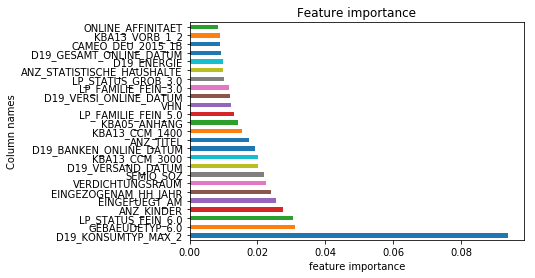

In [176]:
# plot the most important features for the algorithm
pd.Series(gridcv_estimator.feature_importances_, index=mailout_train_X.columns).sort_values(ascending=False).head(25).plot.barh()
plt.title('Feature importance')
plt.ylabel('Column names')
plt.xlabel('feature importance')
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [177]:
# load data
mailout_test = pd.read_csv('mailout_test.csv', sep=',',dtype={'CAMEO_DEUG_2015': object, 'CAMEO_INTL_2015':object} )

In [178]:
# overview of train data
mailout_test_X = mailout_test.iloc[:,1:]

In [179]:
# use the cleaning function to prepare the data for the algorithm
mailout_test_X = cleaning_function2(mailout_test_X)

In [180]:
# check shape for inpute shape of algorithm
mailout_test_X.shape

(42833, 606)

In [181]:
# make predictions
predictions_kaggle = gridcv_estimator.predict(mailout_test_X)

In [182]:
kaggle_sub_df = pd.DataFrame(columns=['LNR', 'RESPONSE'])
kaggle_sub_df['LNR'] = mailout_test['LNR']
kaggle_sub_df['RESPONSE'] = predictions_kaggle

In [183]:
kaggle_sub_df.to_csv('kaggle_sub.csv', index=False)

In [184]:
kaggle_sub_df.shape

(42833, 2)

The score in the kaggle competition is 0.71502 .